In [5]:
from UctZone import UctZone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import seaborn as sns
%config InlineBackend.figure_format='retina'
# plt.style.use('dark_background')


In [6]:
def BSCall(S0, K, sigma, T, r):
    '''
    Inputs:
    S0: initial stock price
    K: strike price
    sigma: volatility of the stock's return
    T: time to maturity (e.g., T=1 for one year)
    r: risk-free interest rate
    
    Output:
    Black-Scholes Call price
    '''
    sigT = sigma * np.sqrt(T)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / sigT
    d2 = d1 - sigT
    
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def delta(S, K, sigma, T, r):
    """
    Calculate the delta of a call option
    S: current stock price
    K: strike price
    sigma: volatility of the stock's return
    T: time to maturity
    r: risk-free interest rate
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

In [4]:
# Change this to test different parameters
alpha = 0.05
eta = 0.05
day = 1  # How many days to simulate (8 hours a day)
K = 100 # Strike price
n = int(3600 * 8 * 10 * day)
sigma_ann = 0.2
sigma = sigma_ann / np.sqrt(252 / day)
r_ann = 0.05
r = r_ann / (360 / day)
beta = 1  # beta = 1 is constant volatility
sigma = 0.01

In [7]:
# simulate the efficient price path
number_of_paths = 1000
error_1 = np.zeros(number_of_paths) # uncertainty zone without noise
error_2 = np.zeros(number_of_paths) # uncertainty zone with noise
error_3 = np.zeros(number_of_paths) # optimal uncertainty zone with noise
A = UctZone(alpha, eta)
for i in tqdm(range(number_of_paths),colour='green',desc='calcualte hedging error'):
    A.get_eff_price_CEV(n, sigma, r=0, beta=beta) # simulate the efficient price path
    A.get_exit_times(L_mode="naive")
    A.get_obs_price(jump_mode="left")
    T = A.T
    t = A.t
    x = A.x
    p = A.p # observed price
    tau = A.tau # stopping time
    portfolio_value_1 = np.zeros(len(tau)) # hedging portfolio value without noise
    portfolio_value_2 = np.zeros(len(tau)) # hedging portfolio value with noise, hedge for every price change
    hedging_position = np.zeros(len(tau))
    call_option_price = np.zeros(len(tau)) # call option price
    # given the stopping time tau, we can calculate the hedging position and portfolio value
    call_option_price[0] = BSCall(x[0], K, sigma, T - t[0], r)
    portfolio_value_1[0] = call_option_price[0]
    portfolio_value_2[0] = call_option_price[0]
    hedging_position[0] = delta(x[0], K, sigma, T - t[0], r) # calculate delta still using efficient price x
    for j in range(1, len(tau)):
        dT = T - t[tau[j]] # Remaining time to maturity
        # Update the portfolio value for changes in the option price and underlying asset
        portfolio_value_1[j] = portfolio_value_1[j-1] + hedging_position[j-1] * (x[tau[j]] - x[tau[j-1]])
        portfolio_value_2[j] = portfolio_value_2[j-1] + hedging_position[j-1] * (p[tau[j]] - p[tau[j-1]])
        hedging_position[j] = delta(x[tau[j]], K, sigma, dT, r)
    call_option_price_final = x[-1] - K if x[-1] > K else 0 # maturity call option price
    error_1[i] = call_option_price_final - portfolio_value_1[-1]
    error_2[i] = call_option_price_final - portfolio_value_2[-1]
    ############################################
    tau_new = [0]
    k = int(A.x[0] / A.alpha) # the first observation
    last_obs = k * A.alpha # the last observation
    l = np.round(A.alpha ** (-0.5)) # the optimal l
    # find the optimal stopping time
    ii = 0
    while ii < len(A.x):
        if A.x[ii] > last_obs + A.alpha * (l - 0.5 + A.eta):
            tau_new.append(ii)
            last_obs = (A.x[ii] // A.alpha) * A.alpha
        elif A.x[ii] < last_obs - A.alpha * (l - 0.5 + A.eta):
            tau_new.append(ii)
            last_obs = (A.x[ii] // A.alpha) * A.alpha
        ii += 1

    tau = tau_new
    ############################################
    portfolio_value_3 = np.zeros(len(tau)) # hedging portfolio value with noise, hedge for every price change
    portfolio_value_3[0] = call_option_price[0]
    hedging_position_3 = np.zeros(len(tau))
    for j in range(1, len(tau)):
        dT = T - t[tau[j]]
        portfolio_value_3[j] = portfolio_value_3[j-1] + hedging_position_3[j-1] * (p[tau[j]] - p[tau[j-1]])
        hedging_position_3[j] = delta(x[tau[j]], K, sigma, dT, r)
    error_3[i] = call_option_price_final - portfolio_value_3[-1]


calcualte hedging error: 100%|██████████| 1000/1000 [15:04<00:00,  1.11it/s]


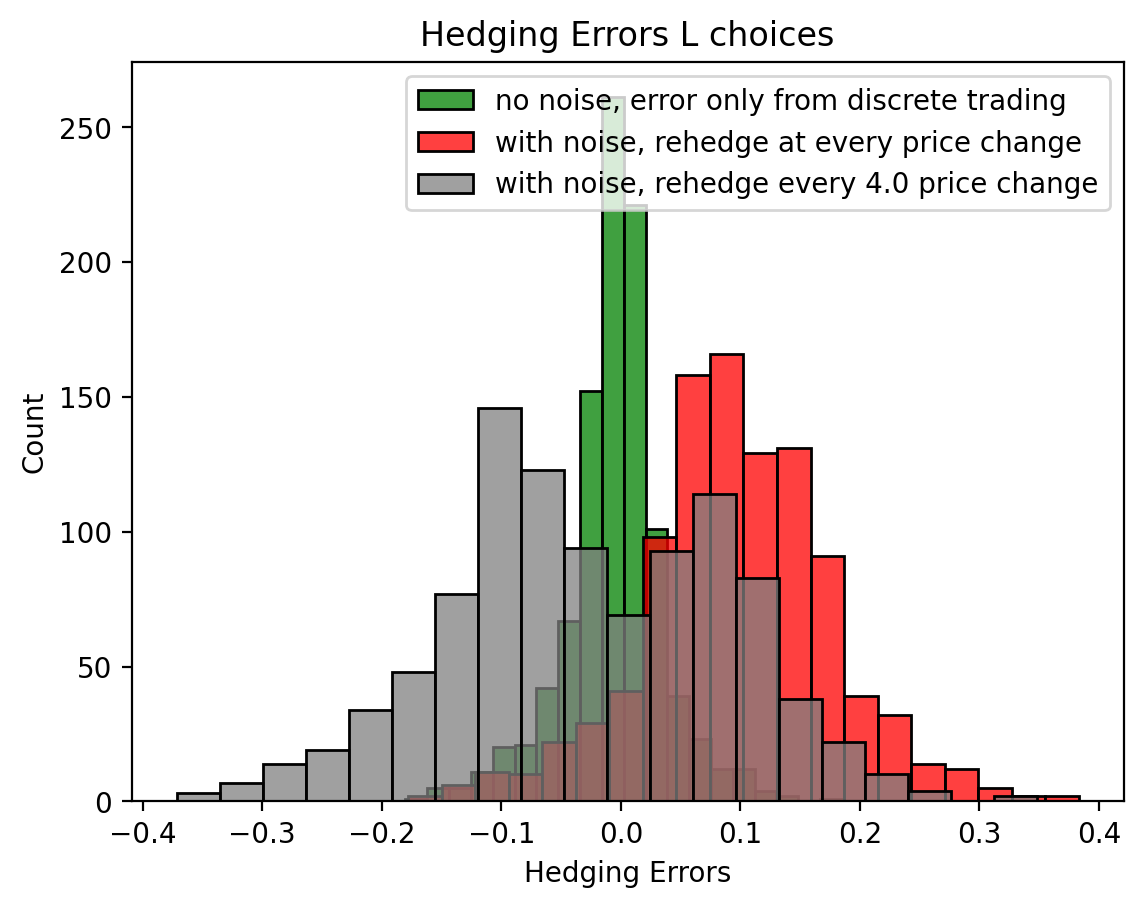

In [9]:
sns.histplot(error_1, label = "no noise, error only from discrete trading", bins = 20, color = 'green')
sns.histplot(error_2, label = "with noise, rehedge at every price change", bins = 20, color = 'red')
sns.histplot(error_3, label = f"with noise, rehedge every {l} price change", bins = 20, color='grey')
plt.xlabel("Hedging Errors")
plt.title("Hedging Errors L choices")
plt.legend()

In [13]:
print(np.std(error_3)/np.std(error_1))
print(np.std(error_2)/np.std(error_1))

2.820086869646886
1.895645449480167


In [11]:
print(np.mean(error_3))
print(np.mean(error_2))

-0.027393654345874163
0.09816325515069209
